# Time Series Clustering with K-Means and Euclidean Distance Matrix for x,y,z


This notebook provides a base clustering for scripted trips without feature engineering and K-Means with k=3. k=3 follows the naive assumption that the cluster structure is only influenced by the labels. 

----
**Specification of experiment:**
- scripted trips
- x,y,z columns of acceleration data was used
- Euclidean Distance was calculated
- No Feature Engineering

-----
**Results:**

1) KMeans Clustering:



    Estimated number of clusters: 3

    True number of clusters: 3

    Homogeneity: 0.449

    Completeness: 0.440

    V-measure: 0.445

    Adjusted MI: 0.439

    Silhouette Coefficient: 0.601




*Assume that transport modes are true clusters

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import get_distribution_of_cluster_labels_for


%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance

In [2]:
# Set to true if all trips should be plotted at the end
plot_all_trips = False

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")
dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]

individual_xyz_file_path = os.path.join(data_dir, "preprocessed","preprocessed_data_individual_euclidean_xyz.csv")

euclidean_distances = pd.read_csv(individual_xyz_file_path,sep=";")
euclidean_distances = euclidean_distances[euclidean_distances["scripted"] == 1]
euclidean_distances = euclidean_distances.reset_index(drop=True)

In [4]:
print(euclidean_distances.shape)
euclidean_distances.head(5)

(911, 1616)


,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,distance_9,...,distance_1606,distance_1607,distance_1608,distance_1609,distance_1610,mode,notes,scripted,token,trip_id
0,0.000000,27.823609,26.115808,13.471125,35.981686,30.434316,32.468222,39.064497,27.660946,23.998385,...,103.397442,116.188026,183.108763,345.031215,428.642706,METRO,scripted,1,355007075245007,0
1,27.823609,0.000000,33.393156,27.759992,31.199391,36.979263,22.178690,43.200119,29.260218,21.752325,...,108.037454,124.111683,178.474925,345.297233,428.620019,METRO,scripted,1,355007075245007,0
2,26.115808,33.393156,0.000000,20.304659,26.889491,10.119632,30.815231,16.579112,11.422631,27.275049,...,99.924364,109.625667,165.326335,332.480561,422.845103,METRO,scripted,1,355007075245007,0
3,13.471125,27.759992,20.304659,0.000000,34.919146,24.745631,31.323753,32.372791,22.646023,23.833539,...,104.992975,115.524044,180.578798,344.423846,429.882985,METRO,scripted,1,355007075245007,0
4,35.981686,31.199391,26.889491,34.919146,0.000000,28.191097,26.761223,29.967852,20.149896,27.808318,...,99.639452,115.825133,161.575808,332.872086,426.237817,METRO,scripted,1,355007075245007,0


In [5]:
from sklearn.preprocessing import scale
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_only = euclidean_distances.drop(categorical_columns,axis=1)
print(trips_only.shape)
trips_only = pd.DataFrame(scale(trips_only),columns=trips_only.columns)

(911, 1611)


------
## Create Base Model with Euclidean Distance and K-Means Clustering

In [6]:
from sklearn.cluster import KMeans
random_state = 0

#Naive asumption of 3 clusters due to 3 labels Walk, Metro and Tram 
kmeans = KMeans(n_clusters=3, random_state=random_state).fit(trips_only)
cluster_labels = kmeans.labels_
euclidean_distances["cluster_labels"]=cluster_labels

### Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [7]:
# how well does it capture the label information

cluster_performance = get_clustering_performance(trips_only, cluster_labels,
                           true_labels=euclidean_distances["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.449

 - Completeness: 0.440

 - V-measure: 0.445

 - Adjusted MI: 0.439

 - Silhouette Coefficient: 0.601

## Visualise Clustering on 2D - TSNE Plot:

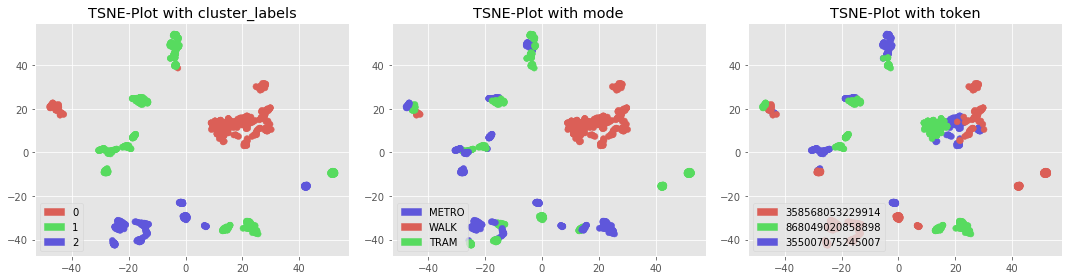

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
reduced = pd.DataFrame(pca.fit_transform(trips_only))

color_encodings = euclidean_distances.loc[:,["cluster_labels","mode","token"]]
plot_2D_tsne_with_coloring_per_targets(reduced, color_encodings)

## Plot the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [9]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,mode
0,16.0,184.0,101.0,METRO
1,282.0,0.0,0.0,WALK
2,26.0,188.0,114.0,TRAM


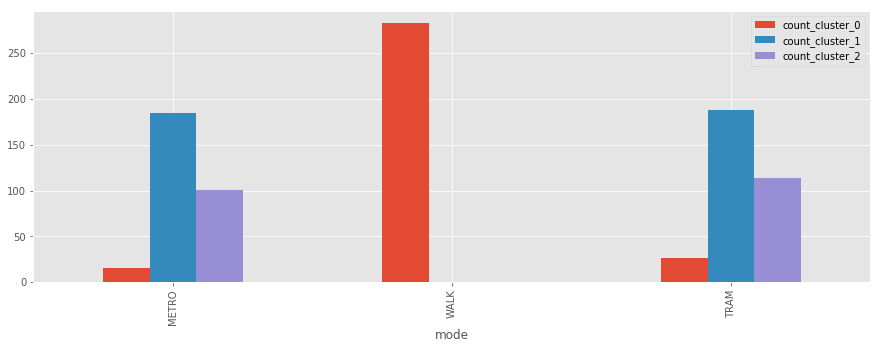

In [10]:
mode_dist_df.set_index("mode").plot(kind="bar",figsize=(15,5));

## Plot distribution of cluster labels for scripted and tokens

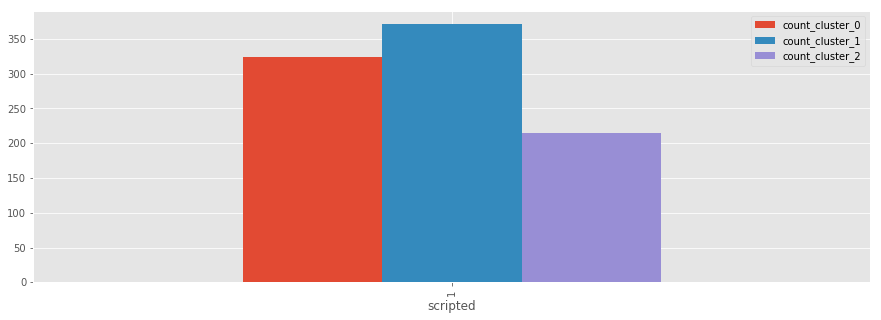

In [11]:
scripted_dist_df = get_distribution_of_cluster_labels_for("scripted", euclidean_distances)
scripted_dist_df.set_index("scripted").plot(kind="bar",figsize=(15,5));

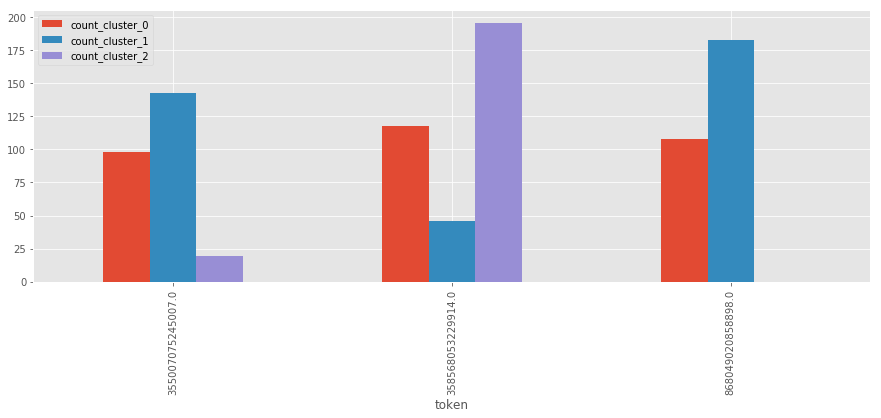

In [12]:
token_dist_df = get_distribution_of_cluster_labels_for("token", euclidean_distances)
token_dist_df.set_index("token").plot(kind="bar",figsize=(15,5));

## Plot all trips with their clustering labels

In [13]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    trips_unpacked = [trip for trip in trips_unpacked if "scripted" in str(trip["annotation"]["notes"][0]).lower()]
    plot_all_trips_with_cluster_coloring(trips_unpacked, euclidean_distances)